# Redes neuronales junto con NeuralODEs

Vamos a mezclar los ejemplos vistos anteriormente, para ello vamos a crear una red neuronal la cual también pase por una NeuralODE

In [285]:
using Flux
using DifferentialEquations
using DiffEqFlux
using Plots
using Flux: train!
using Distributions
using DiffEqFlux, DifferentialEquations
using Statistics, LinearAlgebra, Plots
using Flux.Data: DataLoader, Flux
using Optimization, OptimizationOptimJL
using OptimizationFlux, Random

Comenzamos como simpre generando los dastos que vamos a utilizar

In [297]:
function Noise_Sine(x)
    return sin(2π*x) + rand(Normal(0,0.1))
end;

In [298]:
t_train = Float32.(hcat(-1:0.01:1...))
y_train = Float32.(Noise_Sine.(t_train))
trange = t_train[1,:]
tspan = (t_train[1], t_train[end])

(-1.0f0, 1.0f0)

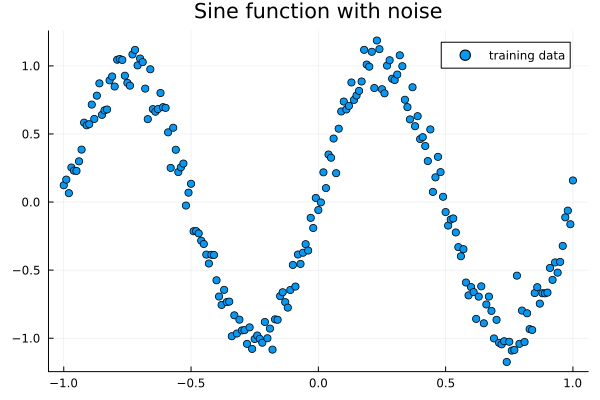

In [299]:
scatter(t_train[1,:], y_train[1,:], label="training data", title="Sine function with noise")

In [300]:
dudt = Chain(Dense(21 => 30, celu),
            Dense(30 => 30, relu),
            Dense(30 => 25, relu),
            Dense(25 => 21, tanh_fast))

Chain(
  Dense(21 => 30, celu),                # 660 parameters
  Dense(30 => 30, relu),                # 930 parameters
  Dense(30 => 25, relu),                # 775 parameters
  Dense(25 => 21, tanh_fast),           # 546 parameters
)                   # Total: 8 arrays, 2_911 parameters, 11.871 KiB.

A esta NN la vamos a hacer pasar por una NerualODE y extraemos los paráemtros de este modelo

In [301]:
diffeqarray_to_array(x) = reshape(x, size(x)[1:2])

n_ode = NeuralODE(dudt, tspan, Tsit5(), save_everystep = false,
reltol = 1e-3, abstol = 1e-3, save_start = false)
n_ode = AugmentedNDELayer(n_ode, 20)
ps = n_ode.p
model = Chain((x, p = n_ode.p) -> n_ode(x, p),
                Array,
                diffeqarray_to_array,
                Dense(21, 1))

Chain(
  var"#149#150"(),
  Array,
  diffeqarray_to_array,
  Dense(21 => 1),                       # 22 parameters
) 

In [302]:
println(size(t_train))
println(size(y_train))
data = DataLoader((t_train, y_train); batchsize=20, shuffle=true)

(1, 201)
(1, 201)


11-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=20)
  with first element:
  (1×20 Matrix{Float32}, 1×20 Matrix{Float32},)

Creamos la función costo para esta red neruronal, igual que antes usamos mse

In [303]:
loss_node(x, y) = mean((model(x) .- y) .^ 2)
# function loss_node()
#     pred = predict_n_ode()
#     pred = vcat(pred.u...)
#     return mean(abs2, pred .- y_train[1,:])
# end

loss_node (generic function with 2 methods)

Seteamos la cantidad de épocas a entrenar, el ratio de aprendizaje y el modelo de optimización que vamos a utilizar. Además creamos la función callback para obtener información de cada época de entrenamiento

In [314]:
opt = ADAM(0.005)
iter = 0
cb = function()
    global iter
    iter += 1
    if iter % 10 == 0
        println("Iteration $iter || Loss = $(loss_node(data.data[1], data.data[2]))")
    end
end

for _ in 1:20
    Flux.train!(loss_node, Flux.params(ps, model), data, opt, cb = cb)
end

Iteration 10 || Loss = 0.03435953


Iteration 20 || Loss = 0.0422254


Iteration 30 || Loss = 0.020741845


Iteration 40 || Loss = 0.02285351


Iteration 50 || Loss = 0.01522398


Iteration 60 || Loss = 0.014531946


Iteration 70 || Loss = 0.035937022
Iteration 80 || Loss = 0.03593925


Iteration 90 || Loss = 0.04063962


Iteration 100 || Loss = 0.05106982


Iteration 110 || Loss = 0.021632133


Iteration 120 || Loss = 0.017666811


Iteration 130 || Loss = 0.018147038


Iteration 140 || Loss = 0.020212855


Iteration 150 || Loss = 0.02211824


Iteration 160 || Loss = 0.06529916


Iteration 170 || Loss = 0.0797016


Iteration 180 || Loss = 0.045842934


Iteration 190 || Loss = 0.04476423


Iteration 200 || Loss = 0.028442489


Iteration 210 || Loss = 0.024794672


Iteration 220 || Loss = 0.020485556


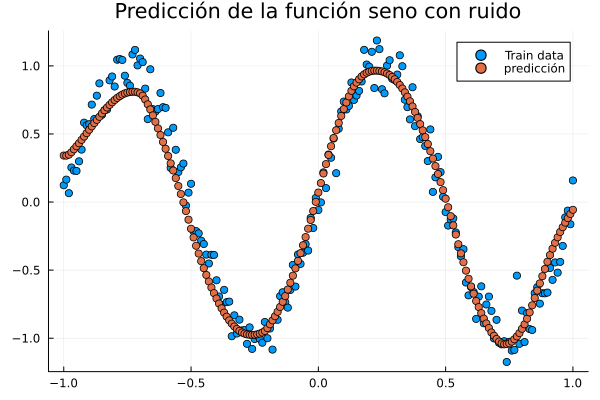

In [315]:
scatter(t_train[1,:],y_train[1,:], label="Train data", title="Predicción de la función seno con ruido")
scatter!(t_train[1,:],model(t_train)[1,:],label = "predicción")

In [306]:
# data = Iterators.repeated((), 1000)
# learning_rate = 0.1
# opt = ADAM(learning_rate)
# iter = 0
# losses = []
# cb = function () #callback function to observe training
#   global iter += 1
#   actual_loss = loss_node()
#   if(iter%100 == 0)
#     cur_pred = predict_n_ode()
#     cur_pred = vcat(cur_pred.u...)
#     println("Epoch: $iter | Loss: $actual_loss")
#     pl = scatter(trange,y_train[1,:],label="data")
#     scatter!(pl,trange,cur_pred,label=false)
#     display(plot(pl))
#   end
#   push!(losses, actual_loss)
# end

# Flux.train!(loss_node, ps, data, opt, cb = cb)
